###  Linear Models and Regularization

#### Importing required libraries and packages


In [1]:
# Importing the necessary libraries and packages

import numpy as np               # For Numerical operations
import matplotlib.pyplot as plt  # For Data visualization
import time                      # For time related functions

####  1. Function to generate an input data matrix X of size NxD for regression

In [2]:
"""
Below is the definition for the "input_matrix_generator" function
It takes two inputs (Arguments):  Sample size N and a generator matrix S of size MxD
and output the input matrix X of size NxD
"""

def input_matrix_generator(N,S):

    # Extracting the shape of the S matrix to get the values for the variables M,D
    M , D = S.shape

    # Generating a random matrix of size NxM where each column has a standard normal distribution and is independent of the other columns
    U = np.random.randn(N,M)

    # Multiplying the random 2-D array "U" (size NxM) with the generator matrix S (size MxD)
    # NxM @ MxD = NxD
    X = U @ S

    return X



N = 100                           # Number of samples
S = np.eye(4,3)                   # Generator matrix (Identity matrix of size 4x3) M=4,D=3
X =  input_matrix_generator(N,S)
print(X.shape)                    # Expected output: (100,3)


# Since S is an Identity matrix in the above example, each column of X will
# remain independent; otherwise we can introduce correlations in the matrix columns of X


(100, 3)


#### 2. Function to generate a target vector t of size Nx1

In [3]:
"""
Below is the definition for the "target_vec_generator" function
It takes three inputs (Arguments): Data matrix X of size NxD, weight vector w of size D+1 and noise variance "sigma"
and output the target vector t of size Nx1
"""

def target_vec_generator(X,w,sigma):

    # Extracting the shape of the X matrix to obtain the values of N and D
    # The value of D is used later for checking dimension mismatch of the weight vector w
    N , D = X.shape



    # Since the size of the weight vector w is D+1, only first 'D' elements are to be considered i.e., to multiply with X (NxD)
    # Checking for dimension mismatch between X and w
    if len(w) != D+1:
        raise ValueError("Mismatch in dimension between X and w")


    # Considering the last element of w ( i.e., w[-1] ) as bias
    bias = w[-1]


    # Multiplying the data matrix of size NxD with w[:-1] (first "D" elements of w)
    # Shape of w[:-1] is (D,). It is a 1D array
    # (N,D) @ (D,1) = (N,1) ('t' vector, which is a 1D array with N elements)

    t1 = X @ w[:-1]                                       # shape: (N,1)


    # Considering Gaussian noise with zero-mean and variance sigma
    noise = np.random.normal(0, sigma, size=(N,1))        # Shape: (N,1)

    # Adding the bias W[-1] (which is the excluded element) and noise
    t = t1 + bias + noise                                 # Shape: (N,1)

    return t


D = 3                                    # Number of features
w = np.array([[0.5] ,
              [1.2] ,
              [-0.8],
              [0.4]])                    # considering a column vector of size D+1 (including bias)as weight vector,  w.shape = (D+1,1)
sigma = 0.1                              # Noise variance
t = target_vec_generator(X, w, sigma)    # [ t = y + noise = Xw + bias + noise ]
print(t.shape)                           # Expected output: (100,1) , N = 100 from prev example in question 1

(100, 1)


#### 3. Examining the behavior of the analytical solver based on pseudo-inverse(pinv)

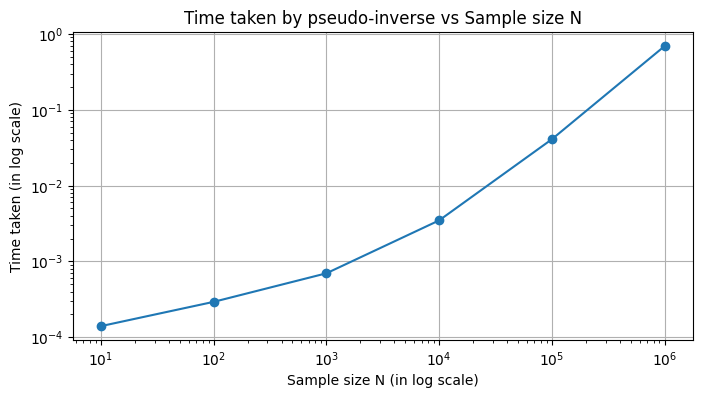

In [5]:
"""
Below is the definition for the "behv_analytical_solv_pinv" function
It takes two inputs (Arguments): List of sample sizes N_values , Number of features D (fixed to 10)
and output the target vector t of size Nx1
"""
def behv_analytical_solv_pinv(N_values, D, trials=10):

    times = []

    for N in N_values:

        S = np.eye(D)  # Identity Generator matrix S

        total_time = 0

        for _ in range(trials):

            # Generating a random data matrix X of size NxD
            X = input_matrix_generator(N, S)

            # Measuring the time taken for pseudo-inverse computation
            start_time = time.time()
            np.linalg.pinv(X)
            end_time = time.time()

            # Accumulating the time taken for this trial
            total_time += (end_time - start_time)

        # Averaging the time over multiple trials for each sample size N to reduce
        # variability in the results caused by fluctuations in system load or random data generation
        average_time = total_time / trials
        times.append(average_time)

    return times


d = 10                                   # Keeping D fixed to 10
N_values = [10**i for i in range(1, 7)]  # N_values range from 10 to 10,00,000
times = behv_analytical_solv_pinv(N_values, d)

# Plotting the results with log scale on both axes
plt.figure(figsize=(8, 4))
plt.loglog(N_values, times, marker='o')
plt.xlabel('Sample size N (in log scale)')
plt.ylabel('Time taken (in log scale)')
plt.title('Time taken by pseudo-inverse vs Sample size N')
plt.grid(True)
plt.show()

##### **OBSERVATIONS:**


*  As N value is increasing, the time taken to solve the pseudo-inverse of X is also increasing
* There is an abrupt increase in the time taken after N = 10^4 samples, indicating increase in computational complexity


#### **Reason for the strange behavior in time taken to solve the problem above a particular value of N:**
##### The pseudo-inverse (Moore-Penrose inverse) solves the least-squares problem.The following can be the reasons for strange behavior after a certain value of N


* **Matrix Size and Computational Complexity**: As N(no.of samples) increases, the computational complexity grows. Beyond a certain value, the time taken increases sharply due to matrix inversion complexity.
* **Numerical Stability** : Larger matrices may lead to issues with numerical stability, especially if they are ill-conditioned. The pseudo-inverse can take longer to compute when it needs to perform more complex numerical adjustments








#### 4. Function to calculate the Normalized Root Mean Squared Error(NRMSE) between a target vector t and a predicted vector y

In [4]:
"""
Below is the definiton for the "normalized_root_MSE" function
It takes two inputs(Arguments):  target vector 't' and a predicted vector 'y'
and output the normalized root mean square error
"""

def normalized_root_MSE(t,y):

  # error = target_vector - predicted_vector
  error = t - y

  # mse : Mean square error of t,y
  mse = np.mean((error)**2)

  # rmse: Root Mean Square Error
  rmse = np.sqrt(mse)

  # nmrse: Normalized Root Mean Square Error
  # Normalizing by the range of t
  nrmse = rmse/(np.max(t) - np.min(t))

  return nrmse

y_pred = X @ w[:-1] + w[-1]  #  y = Xw + b
nrmse = normalized_root_MSE(t,y_pred)
print(nrmse)

0.013038133267868391


#### 5. Function to calculate gradient of mean squared error (MSE) with respect to weights of linear regression

In [5]:
"""
Below is the definiton for the "gradient_mse_w" function
It takes three inputs(Arguments): Input data matrix X, Target vector t and weight vector w
and output the gradient of MSE wrt weights of Linear regression
"""

def gradient_mse_w(X,t,w):

    # X has a shape of (N,D)
    N = X.shape[0]

    # Calculating the predicted vector y = Xw + b
    # prediction_vec of size Nx1
    y = X @ w[:-1] + w[-1]

    # Calculating the error_vector(Nx1) = target_vector(Nx1) - prediction_vec(Nx1)
    error_vec = t - y

    # Calculating the gradient of mse w.r.t weights w[:-1]
    # Gradient wrt weights
    gradient_w = -2 / N * (X.T @ (error_vec))     # [ DxN @ Nx1 = Dx1 ]

    return gradient_w

grad = gradient_mse_w(X, t, w)
print(f"Gradient wrt weights w[:-1]:{grad}")


Gradient wrt weights w[:-1]:[[ 0.01809607]
 [-0.00175198]
 [-0.02065256]]


#### Function to calculate gradient of mean squared error (MSE) with respect to bias of linear regression

In [6]:
"""
Below is the definiton for the gradient_mse_b function
It takes three inputs(Arguments): X is the input data matrix, t is the target vector and weight vector w
and output the gradient of MSE wrt bias
"""

def gradient_mse_b(X,t,w):

    # X has a shape of (N,D)
    N = X.shape[0]

    # Calculating the predicted vector y = Xw + b
    # prediction_vec of size Nx1
    y = X @ w[:-1] + w[-1]

    # Calculating the error_vector(Nx1) = target_vector(Nx1) - prediction_vec(Nx1)
    error_vec = t - y

    # Calculating the gradient of mse w.r.t bias w[-1]
    # Gradient for bias  [ size : 1x1 ]
    gradient_b = -2 / N * np.sum(error_vec)

    return gradient_b

grad = gradient_mse_b(X, t, w)
print(f"Gradient wrt bias:{grad}")


Gradient wrt bias:0.015670561087608562


#### 6. Function to calculate the gradient of L2 norm of weights wrt weights:


*  In L2 regularized linear regression(Ridge regression):

*  Cost function = MSE + λ2(||w||^2),where K is the regularization parameter

*  Using gradient descent method we get:
* Total gradient wrt w = gradient(MSE) + λ2(gradient(||w||^2))


*   Total gradient wrt w = gradient(MSE) + 2(λ2)(w)



*  The added term 2(λ2)(w)  shrinks the weights during training, helping to prevent overfitting






In [7]:
"""
Below is the definition for the "gradient_l2_w" function
It takes one input(argument): weight vector(w)
and returns the gradient of the L2 norm of weights wrt weights
"""
def gradient_l2_w(w):
    # Gradient of L2 norm w.r.t weights is 2*w
    return 2*w                 # shape: (D,1)

print(gradient_l2_w(w[:-1]))   # Giving first 'D' elements of the 'w' vector as an argument since w contains D+1 elements

[[ 1. ]
 [ 2.4]
 [-1.6]]


#### 7. Function to calculate the gradient of L1 norm of weights:

*  In L1 regularized linear regression(Lasso regression):

*  Cost function = MSE + λ1(||w||),where K is the regularization parameter

*  Using gradient descent method we get:
* Total gradient wrt w = gradient(MSE) + λ1(gradient(||w||))

*  The added term + λ1(gradient(||w||)) shrinks the weights during training, helping to prevent overfitting



In [8]:
"""
Below is the definition for the "gradient_l1_w" function
It takes one input(argument): weight vector(w)
and returns the gradient of the L1 norm of weights wrt weights
"""
def gradient_l1_w(w):
    # Gradient of L1 norm: +1 if weight > 0, -1 if weight < 0, 0 if weight == 0
    return np.sign(w)          # shape: (D,1)

print(gradient_l1_w(w[:-1]))   # Giving first 'D' elements of the 'w' vector as an argument

[[ 1.]
 [ 1.]
 [-1.]]


#### 8.Function to perform gradient descent on MSE + λ1 L1 + λ2 L2 for linear regression

In [9]:

"""
Below is the definition for the "gradient_l1_l2" function
It takes the following inputs:

    Arguments:
    - X : Input data matrix
    - t : Target vector
    - w : Initial weight vector
    - lambda1 : Coefficient for L1 regularization
    - lambda2 : Coefficient for L2 regularization
    - learning_rate : Learning rate of the model
    - max_iterations: Maximum number of iterations
    - tolerance : Tolerance for stopping criterion

    output:
    - w : Updated weight vector(including bias term)
"""
def gradient_l1_l2(X, t, w, lambda1, lambda2, learning_rate, max_iterations, tolerance):

    for i in range(max_iterations):

        Total_gradient_w = gradient_mse_w(X,t,w) + lambda1 * gradient_l1_w(w[:-1]) + lambda2 * gradient_l2_w(w[:-1])   # shape: (D,1)
        Total_gradient_b = gradient_mse_b(X,t,w)

        w_new = w[:-1] - learning_rate*(Total_gradient_w)     # w[:-1] is of shape (D,1) and Total_gradient_w is of shape (D,1)
        b_new = w[-1]  - learning_rate*(Total_gradient_b)

        #  Checking convergence based on the change in weights and bias
        if np.linalg.norm(w_new - w[:-1]) < tolerance and abs(b_new - w[-1]) < tolerance:
            break

        # Updating the weights and bias for the next iteration
        w[:-1] = w_new
        w[-1] = b_new

    # Returning the concatenated final weights and bias
    return np.concatenate((w_new, [b_new]))


lambda1 = 0.01
lambda2 = 0.01
learning_rate = 0.01
max_iterations = 1000
tolerance = 1e-6

optimal_parameters = gradient_l1_l2(X, t, w, lambda1, lambda2, learning_rate, max_iterations, tolerance)

print(f"Optimized weights: {optimal_parameters[:-1]} and Optimized bias: {optimal_parameters[-1]} ")


Optimized weights: [[ 0.48053524]
 [ 1.18479578]
 [-0.77153816]] and Optimized bias: [0.3839975] 


##### 9. Impact of Noise Variance (σ) on NRMSE for linear regression using gradient descent

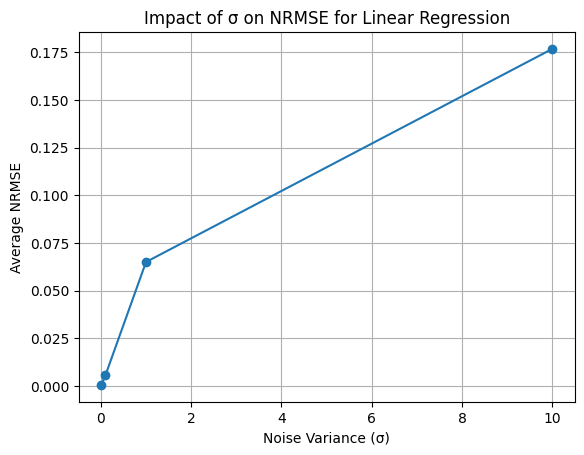

In [12]:
""""
Below is the definiton for the "training" function.
It takes the following inputs: sigma_values, N, D, train_ratio, num_runs, learning_rate, lambda1, lambda2, max_iterations, tolerance
and output the average_nrmse_per_sigma
"""

def training(sigma_values, N, D, train_ratio, num_runs, learning_rate, lambda1, lambda2, max_iterations, tolerance):

    avg_nrmse_per_sigma = []

    for sigma in sigma_values:

        nrmse_values = []

        for _ in range(num_runs):

            # Step 1: Generating data with noise
            G = np.eye(D)                               # Fixed Generator matrix (Identity matrix of size D)
            X = input_matrix_generator(N, G)            # Random data matrix X of size NxD

            w_true = np.random.randn(D+1,1)             # True weights (including bias)
            t = target_vec_generator(X, w_true,sigma)   # Target vector with noise

            # Step 2: Splitting into training and validation sets
            split_no = int(train_ratio * N)
            X_train, X_val = X[:split_no], X[split_no:]
            t_train, t_val = t[:split_no], t[split_no:]

            # Step 3: Initializing the weights
            w_init = np.random.randn(D+1,1)

            # Step 4: Training using gradient descent
            w_final = gradient_l1_l2(X_train, t_train, w_init, lambda1, lambda2, learning_rate, max_iterations, tolerance)

            # Step 5: Predicting on validation set and calculating NRMSE
            y_val = X_val @ w_final[:-1] + w_final[-1]
            nrmse = normalized_root_MSE(t_val, y_val)
            nrmse_values.append(nrmse)

        # Step 6: Calculating average NRMSE for this value of sigma
        avg_nrmse_per_sigma.append(np.mean(nrmse_values))

    return avg_nrmse_per_sigma



sigma_values = [0.01,0.1,1,10]

N = 1000  # Number of data points(samples)
D = 10    # Number of features
train_ratio = 0.8
num_runs = 5
learning_rate = 0.01

# No regularization,so:
lambda1 = 0
lambda2 = 0

max_iterations = 1000
tolerance = 1e-6


avg_nrmse_per_sigma = training(sigma_values, N, D ,train_ratio , num_runs , learning_rate , lambda1 , lambda2 , max_iterations, tolerance)

# Plotting results
plt.plot(sigma_values, avg_nrmse_per_sigma, marker='o')
plt.xlabel('Noise Variance (σ)')
plt.ylabel('Average NRMSE')
plt.title('Impact of σ on NRMSE for Linear Regression')
plt.grid(True)
plt.show()

##### **OBSERVATIONS:**

*   As the noise variance increase ,there is an increase in NRMSE, indicating the deviation of the predicted values from the target values.
*   The lesser the noise, the better the accuracy of the model



#### 10) Impact of N and λ2 on NRMSE

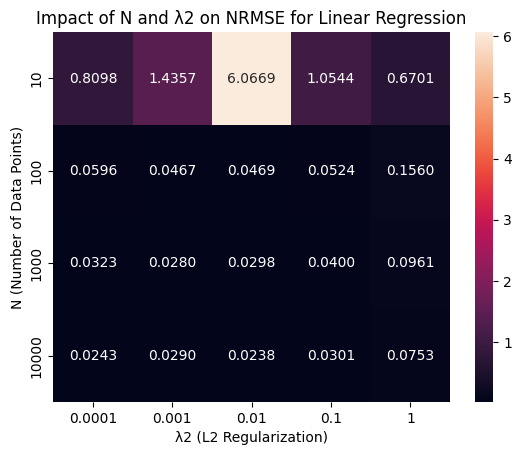

In [19]:
"""
Below is the definition for the "N_l2_NRMSE" function:
It takes the inputs: N_values, lambda2_values, D, sigma, train_ratio , num_runs , learning_rate, max_iterations, tolerance, lambda1=0
and output the average nrmse per combination of N, λ2
"""
def N_l2_NRMSE(N_values, lambda2_values, D, sigma, train_ratio , num_runs , learning_rate, max_iterations, tolerance, lambda1=0):

    avg_nrmse_per_combination = np.zeros((len(N_values), len(lambda2_values)))

    for i, N in enumerate(N_values):
        for j, lambda2 in enumerate(lambda2_values):
            nrmse_values = []

            for _ in range(num_runs):

                # Step 1: Generating data with noise
                G = np.eye(D)                               # Fixed Generator matrix (Identity matrix of size D)
                X = input_matrix_generator(N, G)            # Random data matrix X of size NxD

                w_true = np.random.randn(D+1,1)             # True weights (including bias)
                t = target_vec_generator(X, w_true, sigma)  # Target vector with noise

                # Step 2: Splitting into training and validation sets
                split_no = int(train_ratio * N)
                X_train, X_val = X[:split_no], X[split_no:]
                t_train, t_val = t[:split_no], t[split_no:]

                # Step 3: Initializing weights
                w_init = np.random.randn(D+1,1)

                # Step 4: Training using gradient descent
                w_final = gradient_l1_l2(X_train, t_train, w_init, lambda1, lambda2, learning_rate,max_iterations,tolerance)

                # Step 5: Predicting on validation set and calculate NRMSE
                y_val = np.dot(X_val, w_final[:-1]) + w_final[-1]
                nrmse = normalized_root_MSE(t_val, y_val)
                nrmse_values.append(nrmse)

            # Step 6: Calculating the average NRMSE for this combination of N and lambda2
            avg_nrmse_per_combination[i,j] = np.mean(nrmse_values)

    return avg_nrmse_per_combination


N_values = [10**i for i in range (1,5)]       # Varying number of samples in log scale
lambda2_values = [1e-4, 1e-3, 1e-2, 1e-1, 1]  # Varying L2 regularization strength in log scale
sigma = 0.5                                   # Fixed noise variance
D = 10                                        # Number of features
train_ratio =0.8
num_runs =5
learning_rate =0.01
max_iterations = 1000
tolerance = 1e-6


avg_nrmse_per_combination = N_l2_NRMSE(N_values, lambda2_values, D, sigma, train_ratio , num_runs , learning_rate, max_iterations, tolerance)

# Plotting results as a heatmap
import seaborn as sns
sns.heatmap(avg_nrmse_per_combination, xticklabels=lambda2_values, yticklabels=N_values, annot=True, fmt='.4f')
plt.xlabel('λ2 (L2 Regularization)')
plt.ylabel('N (Number of Data Points)')
plt.title('Impact of N and λ2 on NRMSE for Linear Regression')
plt.show()

#### **OBSERVATIONS:**


*  The boxes in the above heatmap contains the NRMSE values for each combination of N and λ2

* Increasing 'N' lead to decrease in NRMSE, showing that the model performs better with more data
* When λ2 increases,initially NRMSE may decrease, but as λ2
becomes too large, NRMSE may rise again due to underfitting
*  For small values of N and large λ2, NRMSE is high(indicating poor performance)
* For large N and moderate λ2 [From the above plot for N = 10000 and λ2 = 0.01], NRMSE is the least(indicating better generalization)

#### 11) Impact of λ1 on Variable Elimination


*   The L1 norm (Lasso) encourages sparsity in the weight vector, potentially eliminating variables (setting weights to zero)


*  A successful outcome of using L1 regularization in uncorrelated data is the generation of a sparse solution where only a few features retain non-zero weights





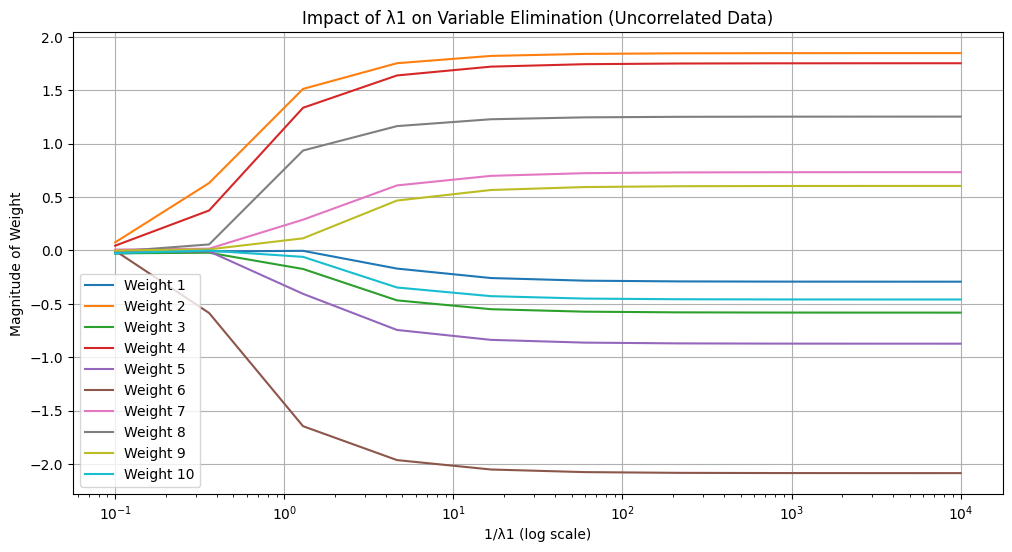

In [40]:
"""
Below is the definition for the "l1_var_elim" function:
It takes the inputs: X, t, lambda1_values,  learning_rate, max_iters, num_runs, lambda2=0
and output the array containing weights_per_lambda1
"""
def l1_var_elim(X, t, lambda1_values, learning_rate, max_iters, tolerance, num_runs, lambda2=0):
    weights_per_lambda1 = []

    for lambda1 in lambda1_values:
        weights_list = []

        for _ in range(num_runs):

            w_init = np.random.randn(D+1, 1)
            w_final = gradient_l1_l2(X, t, w_init, lambda1, lambda2, learning_rate, max_iters, tolerance)

            weights_list.append(w_final[:-1].flatten())  # Excluding bias and flatten to 1D  (D,1) --> (D,)
            # print(weights_list)

        # Calculating the average the weights for this lambda1
        weights_per_lambda1.append(np.mean(weights_list, axis = 0))   # Averaging all terms in a row

    return np.array(weights_per_lambda1)



N = 1000
D = 10
sigma = 0.5
lambda1_values = np.logspace(-4, 1, 10)  # Varying λ1 values on a log scale
learning_rate = 0.01
max_iters = 1000
tolerance=1e-6
num_runs = 5


# X, t are generated outside the function so as to keep them fixed across diff runs
G = np.eye(D)                               # Fixed Generator matrix (Identity matrix of size D)
X = input_matrix_generator(N, G)            # Random data matrix X of size NxD

w_true = np.random.randn(D+1, 1)            # True weights (including bias)
t = target_vec_generator(X, w_true, sigma)  # Target vector with noise

# Running the experiment for uncorrelated data
weights_per_lambda1 = l1_var_elim(X, t, lambda1_values, learning_rate, max_iters,tolerance, num_runs)


# Plotting results for uncorrelated data
plt.figure(figsize=(12, 6))

# Plotting each feature's weights for different λ1 values
for i in range(weights_per_lambda1.shape[1]):          # Loop over each feature (D)
    plt.plot(1 / lambda1_values, weights_per_lambda1[:, i], label=f'Weight {i+1}')

plt.xscale('log')  # Log scale for x-axis (1/λ1)
plt.xlabel('1/λ1 (log scale)')
plt.ylabel('Magnitude of Weight')
plt.title('Impact of λ1 on Variable Elimination (Uncorrelated Data)')
plt.legend()       # Adding legend to differentiate the weights
plt.grid(True)
plt.show()

#### **Observations from the Uncorrelated Data Plot:**


##### Weights Decreasing: The majority of the weights trend downwards as λ1 ​increases (moving right to left on the x-axis). This indicates that L1 regularization effectively shrinks the coefficients of less important features towards zero
##### Variable Elimination: L1 works well for uncorrelated data because it can easily distinguish between important and irrelevant features, driving irrelevant weights to zero.




##### Significant Features: The weights for features that are more important remain higher and more stable compared to less significant features. This suggests that L1 regularization is successfully identifying and retaining relevant features



##### Some Fluctuations: The presence of minor fluctuations in some weight trajectories indicates sensitivity to the changes in λ1, but overall, the downward trend is evident



##### Plateauing: As λ1 becomes large, weights tend to stabilize and level off, suggesting that further increases in λ1 do not significantly impact the retained weights



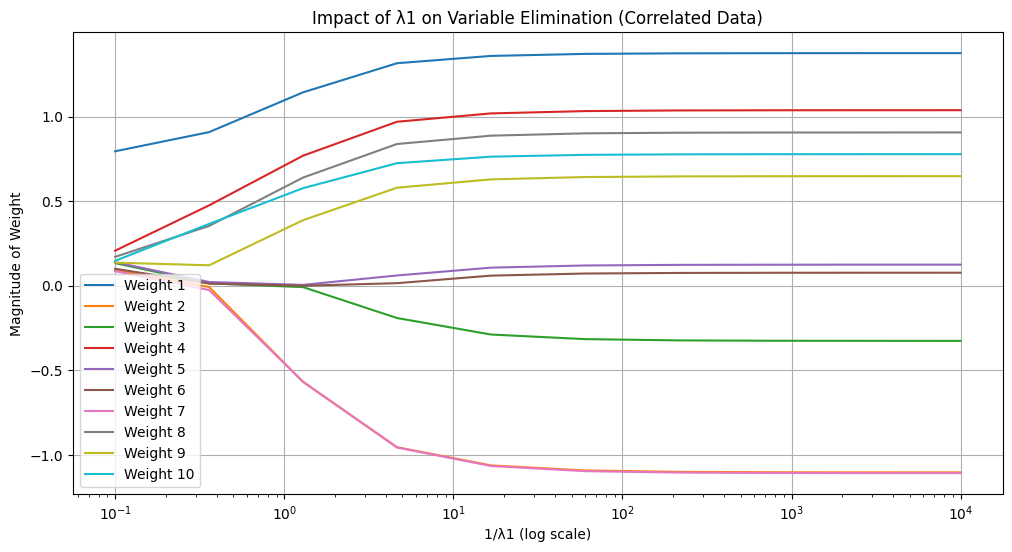

In [96]:
# Introducing correlations in the columns of X
correlation_strength = 0.8
S_correlated = np.eye(D) + correlation_strength * np.ones((D, D))
X_correlated = input_matrix_generator(N, S_correlated)

sigma = 0.5
w_true = np.random.randn(D+1,1)
t = target_vec_generator(X_correlated, w_true, sigma)


# Running experiment for correlated data
weights_correlated = l1_var_elim(X_correlated, t, lambda1_values, learning_rate, max_iters,tolerance, num_runs)

# Plotting results for uncorrelated data
plt.figure(figsize=(12, 6))

# Plotting each feature's weights for different λ1 values
for i in range(weights_correlated.shape[1]):          # Loop over each feature (D)
    plt.plot(1 / lambda1_values, weights_correlated[:, i], label=f'Weight {i+1}')

plt.xscale('log')     # Log scale for x-axis (1/λ1)
plt.xlabel('1/λ1 (log scale)')
plt.ylabel('Magnitude of Weight')
plt.title('Impact of λ1 on Variable Elimination (Correlated Data)')
plt.legend()          # Adding legend to differentiate the weights
plt.grid(True)
plt.show()



#### **Observations for the Correlated Data Plot**:


* The results from uncorrelated and correlated data are different




*  The weights for correlated data fluctuated less dramatically compared to the uncorrelated data, indicating more stability in the presence of correlated features

*  Most weights clustered around smaller values (near zero), suggesting that L1 regularization is less effective in eliminating these correlated features
*  The curves are more homogeneous, indicating that the presence of correlation makes it difficult to assess individual feature importance


* The results demonstrate that correlations among features diminish the ability of L1 regularization to effectively eliminate less relevant variables









#### 12) Grouping Effect of Elastic Net on Correlated Columns of X


The Elastic Net regularization combines both L1 (Lasso) and L2 (Ridge) penalties. It's particularly useful in cases where there are correlated features. Lasso tends to select one feature from a group of correlated ones, while Ridge shrinks the coefficients of correlated features together. The Elastic Net provides a balance between the two and demonstrates a grouping effect, where correlated features are selected together

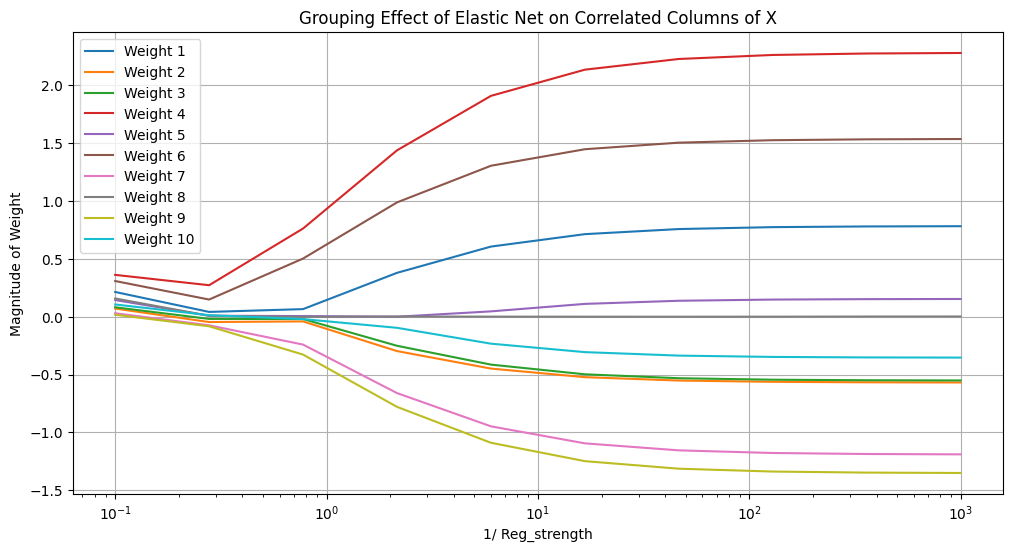

In [99]:
"""
Below is the definition for the "elastic_net" function
It takes the inputs: X, t, Reg_strengths, learning_rate, max_iters, tolerance, num_runs
and output an array containing weights per regularization strength
"""

def elastic_net(X, t, Reg_strengths, learning_rate, max_iters, tolerance, num_runs):
    weights_per_reg = []

    for i in Reg_strengths:
        weights_list = []

        for _ in range(num_runs):

            w_init = np.random.randn(D+1,1)
            w_final = gradient_l1_l2(X, t, w_init, i, i, learning_rate, max_iters, tolerance)

            weights_list.append(w_final[:-1].flatten())  # Excluding bias and flatten to 1D  (D,1) --> (D,)


        # Calculating the average the weights for this lambda1
        weights_per_reg.append(np.mean(weights_list, axis=0))

    return np.array(weights_per_reg)


N = 1000
D = 10
sigma = 0.5
correlation_strength = 0.8
Reg_strengths = np.logspace(-3, 1, 10) # Regularization strengths ( 10 values between 10^-3 to 10^1)
l1_ratio = 0.5                         # Mixing between L1 and L2 regularization

# Generating correlated data
S_correlated = np.eye(D) + correlation_strength * np.ones((D, D))
X_correlated = input_matrix_generator(N, S_correlated)

w_true = np.random.randn(D+1,1)
t = target_vec_generator(X_correlated, w_true, sigma)

# Running the experiment with Elastic Net
weights_elastic_net = elastic_net(X_correlated, t, Reg_strengths, learning_rate, max_iters, tolerance, num_runs)

# Plotting the results
plt.figure(figsize=(12, 6))
for i in range(weights_elastic_net.shape[1]):
    plt.plot(1 / Reg_strengths, weights_elastic_net[:,i], label=f'Weight {i+1}')

plt.xscale('log')
plt.xlabel('1/ Reg_strength')
plt.ylabel('Magnitude of Weight')
plt.title('Grouping Effect of Elastic Net on Correlated Columns of X')
plt.legend()          # Adding legend to differentiate the weights
plt.grid(True)
plt.show()

#### OBSERVATIONS:



*  As the regularization strength increases,
Elastic Net will tend to group the weights of correlated features together. The grouping effect is observed as multiple correlated weights remain similar in magnitude and are either retained or eliminated together, unlike in lasso where only one of the correlated features is selected

*  When using Elastic Net, correlated columns will have similar magnitudes in their weights. As opposed to Lasso (where one column gets selected), Elastic Net will tend to group them together.

#### Comparing L1(Uncorrelated & Correlated) and Elastic Net results

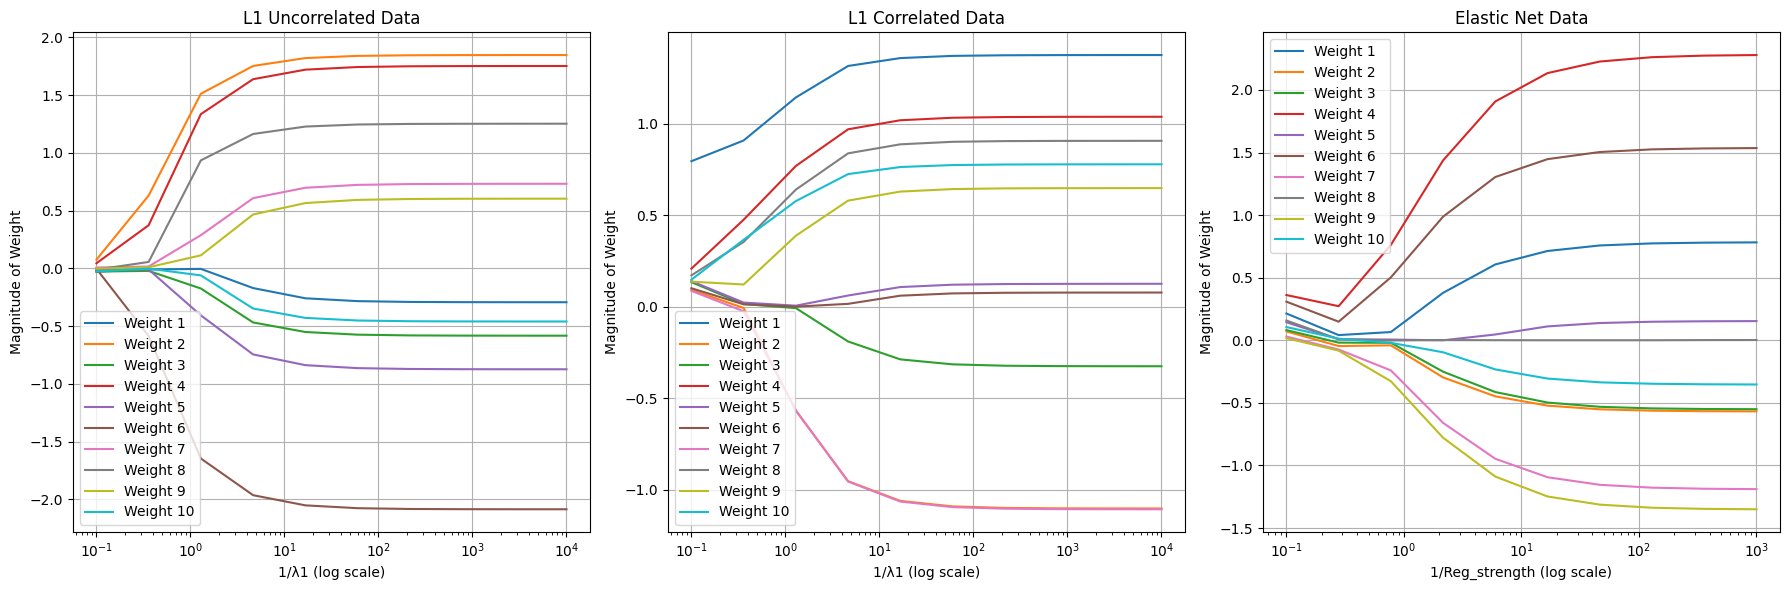

In [100]:
# Creating a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# First plot: L1 Uncorrelated Data
for i in range(weights_per_lambda1.shape[1]):
    axes[0].plot(1 / lambda1_values, weights_per_lambda1[:, i], label=f'Weight {i+1}')
axes[0].set_xscale('log')
axes[0].set_title('L1 Uncorrelated Data')
axes[0].set_xlabel('1/λ1 (log scale)')
axes[0].set_ylabel('Magnitude of Weight')
axes[0].legend()
axes[0].grid(True)

# Second plot: L1 Correlated Data
for i in range(weights_correlated.shape[1]):
    axes[1].plot(1 / lambda1_values, weights_correlated[:, i], label=f'Weight {i+1}')
axes[1].set_xscale('log')
axes[1].set_title('L1 Correlated Data')
axes[1].set_xlabel('1/λ1 (log scale)')
axes[1].set_ylabel('Magnitude of Weight')
axes[1].legend()
axes[1].grid(True)

# Third plot: Elastic Net Data
for i in range(weights_elastic_net.shape[1]):
    axes[2].plot(1 / Reg_strengths, weights_elastic_net[:, i], label=f'Weight {i+1}')
axes[2].set_xscale('log')
axes[2].set_title('Elastic Net Data')
axes[2].set_xlabel('1/Reg_strength (log scale)')
axes[2].set_ylabel('Magnitude of Weight')
axes[2].legend()
axes[2].grid(True)

# Displaying the plots
plt.tight_layout()
plt.show()


#### 13) Function for Generating Linear Binary Classification Vector t with Noise Variance σ

#### To generate a linear binary classification vector, we can apply a logistic transformation to a linear combination of features and then introduce noise





### For uncorrelated data

In [50]:
"""
Below is the definition for the "gen_binary_classification" function.
It takes the inputs: X, w, sigma
and output the Linear Binary classification vector t
""" 
def gen_binary_class_vec(X, w, sigma):

    # Computing the linear combination of X and w
    linear_combination = np.dot(X, w[:-1]) + w[-1]

    # Adding Gaussian noise
    noisy_combination = linear_combination + np.random.normal(0, sigma, size=linear_combination.shape)

    # Applying the sigmoid function to get probabilities
    probabilities = 1 / (1 + np.exp(-noisy_combination))

    # Generating binary labels by thresholding at 0.5 [values above 0.5 are classified as 1, others as 0]
    t = (probabilities >= 0.5).astype(int)

    return t


S = np.eye(D)                               # Identity matrix of size D
X = input_matrix_generator(N, S)            # Random data matrix X of size NxD
w_true_uncorr = np.random.randn(D+1,1)      # True weights (including bias)

t_binary_uncorr = gen_binary_class_vec( X, w_true_uncorr, 0.5)
print(t_binary_uncorr[:10])                 # First 10 labels

[[0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]]


### For correlated data

In [51]:
"""
Below is the definition for the "gen_binary_classification" function.
It takes the inputs: X, w, sigma
and output the Linear Binary classification vector t
"""

def gen_binary_class_vec(X, w, sigma):

    # Computing the linear combination of X and w
    linear_combination = np.dot(X, w[:-1]) + w[-1]

    # Adding Gaussian noise
    noisy_combination = linear_combination + np.random.normal(0, sigma, size=linear_combination.shape)

    # Applying the sigmoid function to get probabilities
    probabilities = 1 / (1 + np.exp(-noisy_combination))

    # Generating binary labels by thresholding at 0.5 [values above 0.5 are classified as 1, others as 0]
    t = (probabilities >= 0.5).astype(int)

    return t


# Generating correlated data with noise
correlation_strength = 0.8
S_correlated = np.eye(D) + correlation_strength * np.ones((D, D))
X_correlated = input_matrix_generator(N, S_correlated)             # Correlated data matrix NxD
w_true_corr = np.random.randn(D+1,1)                               # True weights (including bias)

# Generating binary classification vector using correlated data
t_binary_corr = gen_binary_class_vec(X_correlated, w_true_corr, 0.5)
print(t_binary_corr[:10])                                              # Printing first 10 labels


[[0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]]


#### **OBSERVATIONS:**
*  For binary classification, the target vector t contains only two values: 0 and 1. The above function adds the noise to the linear combination of the features and then apply a threshold to binarize the results


#### 14) Function for Computing Gradient of Binary Cross-Entropy for Logistic Regression

#### For Uncorrelated data

In [52]:
"""
Below is the definition for the "gradient_binary_cross_entropy" function.
It takes the inputs: X, t, w
and output the gradient of binary cross-entropy for logistic regression
"""

def gradient_binary_cross_entropy(X, t, w):

    # Computing the predicted probabilities using the sigmoid function
    linear_combination = np.dot(X, w[:-1]) + w[-1]
    probabilities = 1 / (1 + np.exp(-linear_combination))        # Sigmoid to get probabilities

    # Computing the gradient
    gradient_w = np.dot(X.T, (probabilities - t)) / len(t)
    gradient_b = np.mean(probabilities - t)                      # Gradient for bias term

    return np.concatenate((gradient_w, [[gradient_b]]))


gradient = gradient_binary_cross_entropy(X, t_binary_uncorr, w_true_uncorr)
print(gradient)


[[-0.02881782]
 [-0.0099237 ]
 [-0.01187851]
 [-0.01043942]
 [ 0.01294569]
 [ 0.010935  ]
 [-0.00209159]
 [-0.00338041]
 [-0.02403425]
 [-0.0129472 ]
 [-0.05108098]]


##### INFERENCE: Positive values indicate that increasing the corresponding weight would increase the loss, while negative values suggest that increasing the corresponding weight would decrease the loss.

#### For Correlated data

In [53]:
"""
Below is the definition for the "gradient_binary_cross_entropy" function.
It takes the inputs: X, t, w
and output the gradient of binary cross-entropy for logistic regression
"""

def gradient_binary_cross_entropy(X, t, w):

    # Computing the predicted probabilities using the sigmoid function
    linear_combination = np.dot(X, w[:-1]) + w[-1]
    probabilities = 1 / (1 + np.exp(-linear_combination))        # Sigmoid to get probabilities

    # Computing the gradient
    gradient_w = np.dot(X.T, (probabilities - t)) / len(t)
    gradient_b = np.mean(probabilities - t)                      # Gradient for bias term

    return np.concatenate((gradient_w, [[gradient_b]]))


gradient = gradient_binary_cross_entropy(X_correlated, t_binary_corr, w_true_corr)
print(gradient)


[[-0.01209247]
 [-0.01288998]
 [-0.01290867]
 [-0.02437299]
 [-0.00959986]
 [-0.01488011]
 [-0.01236481]
 [-0.01453987]
 [-0.0156527 ]
 [-0.01248334]
 [-0.00568616]]


#### Binary Cross-Entropy Loss and Gradient Calculation along with L2 regularization for Uncorrelated data

In [54]:
"""
Below is the definition for the "gradient_binary_cross_entropy" function.
It takes the inputs: X, t, w, lambda2
and output the gradient of binary cross-entropy along with l2 for logistic regression
"""

def gradient_binary_cross_entropy_l2(X, t, w, lambda2):

    # Computing the predicted probabilities using the sigmoid function
    linear_combination = np.dot(X, w[:-1]) + w[-1]
    probabilities = 1 / (1 + np.exp(-linear_combination))        # Sigmoid to get probabilities

    # Computing the gradient
    gradient_w = np.dot(X.T, (probabilities - t)) / len(t)  + lambda2 * 2 * w[:-1]
    gradient_b = np.mean(probabilities - t)                      # Gradient for bias term

    return np.concatenate((gradient_w, [[gradient_b]]))


gradient = gradient_binary_cross_entropy_l2(X, t_binary_uncorr, w_true_corr, lambda2)
print(gradient)


[[-0.26616757]
 [ 0.051076  ]
 [-0.18647096]
 [ 0.04031102]
 [ 0.10670187]
 [-0.0343585 ]
 [ 0.26416133]
 [ 0.1712934 ]
 [-0.17341261]
 [ 0.0873813 ]
 [-0.20940568]]


#### Updating weights using gradient descent to minimize the binary cross-entropy loss with L2 regularization

In [55]:
"""
Below is the definition for the "log_reg_grad_des_l2" function
It takes the inputs: X, t, w, lambda2, learning_rate, max_iterations, tolerance
and output the updated weight vector
"""

def log_reg_grad_des_l2(X, t, w, lambda2, learning_rate, max_iterations, tolerance):

    for i in range(max_iterations):
        gradient = gradient_binary_cross_entropy_l2(X, t, w, lambda2)
        w_new = w - learning_rate * gradient
        if np.linalg.norm(w_new - w) < tolerance:
            break
        w = w_new
    return w

#### 15) Repeating Experiment 10 for binary classification
#### Impact of N and λ2 on the NRMSE for  binary classification using gradient descent

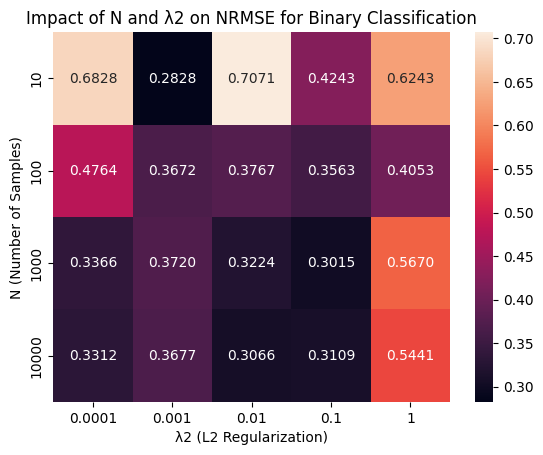

In [105]:
"""
Below is the definition for the "N_l2_binary_class" function
It takes the inputs: N_values, lambda2_values, D, sigma, train_ratio , num_runs , learning_rate, max_iterations, tolerance, lambda1=0
and output the average nrmse per combination of N, λ2 for binary classification
"""

def N_l2_binary_class( N_values, lambda2_values, D, sigma, train_ratio , num_runs , learning_rate, max_iterations, tolerance, lambda1=0):

    avg_nrmse_per_combination = np.zeros((len(N_values), len(lambda2_values)))

    for i, N in enumerate(N_values):
        for j, lambda2 in enumerate(lambda2_values):
            nrmse_values = []

            for _ in range(num_runs):

                # Step 1: Generating data with noise
                S = np.eye(D)                               # Identity matrix of size D
                X = input_matrix_generator(N, S)            # Random data matrix X of size NxD

                w_true = np.random.randn(D+1,1)             # True weights (including bias)
                t = gen_binary_class_vec(X, w_true, sigma)

                # Step 2: Splitting into training and validation sets
                split_idx = int(train_ratio * N)
                X_train, X_val = X[:split_idx], X[split_idx:]
                t_train, t_val = t[:split_idx], t[split_idx:]

                # Step 3: Initializing weights
                w_init = np.random.randn(D+1,1)

                # Step 4: Training using gradient descent
                w_final = log_reg_grad_des_l2(X_train, t_train, w_init, lambda2, learning_rate, max_iterations, tolerance)

                # Step 5: Predicting on validation set and calculate NRMSE
                y_pred = 1 / (1 + np.exp(-np.dot(X_val, w_final[:-1]) - w_final[-1]))  # Sigmoid predictions
                y_pred_class = (y_pred > 0.5).astype(int)                              # Converting to binary

                rmse = np.sqrt(np.mean((t_val - y_pred_class) ** 2))
                # Add 1e-8 to avoid zero division
                nrmse = rmse / (np.max(t) - np.min(t) + 1e-8)
                nrmse_values.append(nrmse)

            # Step 6: Calculating average NRMSE for this combination of N and lambda2
            avg_nrmse_per_combination[i, j] = np.mean(nrmse_values)

    return avg_nrmse_per_combination

N_values = [10**i for i in range (1,5)]       # Varying number of samples in log scale
lambda2_values = [1e-4, 1e-3, 1e-2, 1e-1, 1]  # Varying L2 regularization strength in log scale
sigma = 0.5                                   # Fixed noise variance
D = 10                                        # Number of features
train_ratio =0.8
num_runs = 5
learning_rate = 0.01
max_iterations = 1000
tolerance = 1e-6

# Running the experiment for binary classification
avg_nrmse_per_combination_binary = N_l2_binary_class(N_values, lambda2_values, D, sigma, train_ratio , num_runs , learning_rate, max_iterations, tolerance)

# Plotting results as a heatmap
import seaborn as sns
sns.heatmap(avg_nrmse_per_combination_binary, xticklabels=lambda2_values, yticklabels=N_values, annot=True, fmt='.4f')
plt.xlabel('λ2 (L2 Regularization)')
plt.ylabel('N (Number of Samples)')
plt.title('Impact of N and λ2 on NRMSE for Binary Classification')
plt.show()



#### **OBSERVATIONS:**
*   Larger datasets (N) lead to better generalization and lower NRMSE.


* Moderate regularization (λ2)avoids both overfitting and underfitting.

*   Both very small and very large(λ2)
  values harm model performance.


*  Though NRMSE value decrease initially as λ2 value is increased, further increasing it lead to large NRMSE values and instability is seen in the trend of NRMSE values
*  At higher N and moderate λ2 values, stable and low NRMSE values are seen




*  From the above heat map at N = 10000 and λ2 = 0.01 the NRMSE is least






### ***REFERENCES:***










#### Bishop's book Sections 3, 3.1, 3.1.1, 3.1.2, 3.1.4, 3.2
[ https://drive.google.com/file/d/1Asl0RgINkfWCOB0vlKmuUmOEVIWbbvz-/view?usp=drive_link ]
#### Lecture slides: EE353_769 07 Linear Regression  
[https://drive.google.com/file/d/1ZLn31yQnSlc4PXEsVrb_u-FFkcFARznf/view?usp=drive_link ]
#### Bishop's book Sections 4.2, 4.2.1, 4.2.2, 4.3.2 
[https://drive.google.com/file/d/1Asl0RgINkfWCOB0vlKmuUmOEVIWbbvz-/view?usp=drive_link]
#### Lecture slides: EE353_769 08 Linear Classification 
[ https://drive.google.com/file/d/1uEaHob2ujzIxieJ1X3FEM6OZy7qui488/view?usp=sharing ]




## ***THANK YOU!!*** 😀